In [4]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc
from PIL import ImageFile
import torch
import open_clip
from PIL import Image
import concurrent
import pandas as pd


ImageFile.LOAD_TRUNCATED_IMAGES = True
torch.set_grad_enabled(False)

/Users/pshishodia/projects/Fashion/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FILENAMES_DF_PATH = 'assets-224-filename-kaggle.csv'
filename_df = pd.read_csv(FILENAMES_DF_PATH)
filename_df.head()

In [5]:
def get_file_path_from_url(url):
    return '-'.join(url.split('/')[5:])

products_df = pd.read_csv('products.csv')
products_df['filename'] = products_df['searchImage'].apply(get_file_path_from_url)
products_df = products_df.drop(columns=['Unnamed: 0'])

final_df = pd.merge(filename_df, products_df, left_on='0', right_on='filename', how='left').drop_duplicates(subset='filename', keep='first').reset_index(True)


In [5]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

/Users/pshishodia/projects/Fashion/venv/lib/python3.12/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoi

In [6]:
final_df = pd.read_csv('products_minimal.csv')

In [304]:
image_to_search = Image.open('image-to-search.jpeg')

In [305]:
encoding = model.encode_image(preprocess(image_to_search).unsqueeze(0))

In [316]:
tokenizer('parachute pants with pleats')

torch.Size([1, 77])

In [7]:
image_embeddings = torch.load('image_embeddings_kaggle.pt', map_location=torch.device('cpu'))
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

/var/folders/v5/5dgh50p539z_yrpw03gf01p80000gn/T/ipykernel_66276/4000776036.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings = torch.load('image_embeddin

In [14]:
def get_file_path_from_url(url):
    return '-'.join(url.split('/')[5:])

def plotKNN(base_embedding, nrow=5, ncol=5, figsize=(10, 10), title=""):
    less_than_1000_indices = final_df[final_df['price'] <= 1000].index.tolist()
    probs = torch.nn.functional.cosine_similarity(image_embeddings[less_than_1000_indices], base_embedding.view(1, 512))

    top_ids = probs.topk(nrow * ncol).indices
    top_indices = torch.tensor([less_than_1000_indices[i] for i in top_ids])
    products = final_df.loc[top_indices.tolist()].to_dict('records')
    top_scores = probs[top_ids]
    assert len(products) == len(top_indices.tolist())


    fig, axs = plt.subplots(nrow, ncol, figsize=(20, 20))
    fig.suptitle(f"{title}", fontsize=20, fontname='Comic Sans MS')
    
    for i, (product, score, ix) in enumerate(zip(products, top_scores, top_indices)):
        # print('product: ', product)
        img_path = 'assets-224/' + get_file_path_from_url(product['searchImage'])
        image = Image.open(img_path)
        axs[i//ncol][i%ncol].imshow(image)
        axs[i//ncol][i%ncol].set_title(f"{int(score * 100)/100}, {ix}, {product['price']}")

        axs[i//ncol][i%ncol].axis('off')

    plt.show()
    for ix in top_indices.tolist():
        url = 'https://www.myntra.com/' + final_df.iloc[ix]['landingPageUrl']
        print(f'{ix} : {url}')

def mashup(image_ixs, nrow=5, ncol=5, figsize=(10, 10)):
    mean_embedding = image_embeddings[torch.tensor(image_ixs)].mean(dim=0)
    mean_embedding /= mean_embedding.norm()

    plotKNN(mean_embedding, nrow, ncol, figsize, title='Mashup :' + str(image_ixs))

def ask(query, nrow=5, ncol=5, figsize=(10, 10)):
    text = tokenizer([query])
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    plotKNN(text_features, nrow, ncol, figsize, title=query)

def similar(image_ix, nrow=5, ncol=5, figsize=(10, 10)):
    base_image_feature = image_embeddings[image_ix]
    base_image_feature /= base_image_feature.norm()
    plotKNN(base_image_feature, nrow, ncol, figsize, title=f'Similar: {image_ix}')

def mashup_all(image_ixs, query, nrow=5, ncol=5, figsize=(20, 20), alpha=0.5):
    image_mean_embedding = image_embeddings[torch.tensor(image_ixs)].mean(dim=0)
    image_mean_embedding /= image_mean_embedding.norm()

    query_embedding = model.encode_text(tokenizer([query]))
    query_embedding /= query_embedding.norm(dim=-1, keepdim=True)

    final_embedding = alpha * image_mean_embedding + (1 - alpha) * query_embedding.squeeze()
    final_embedding /= final_embedding.norm(dim=0)
    plotKNN(final_embedding, nrow, ncol, figsize, title='Mashup: ' + str(image_ixs) + ', ' + query)


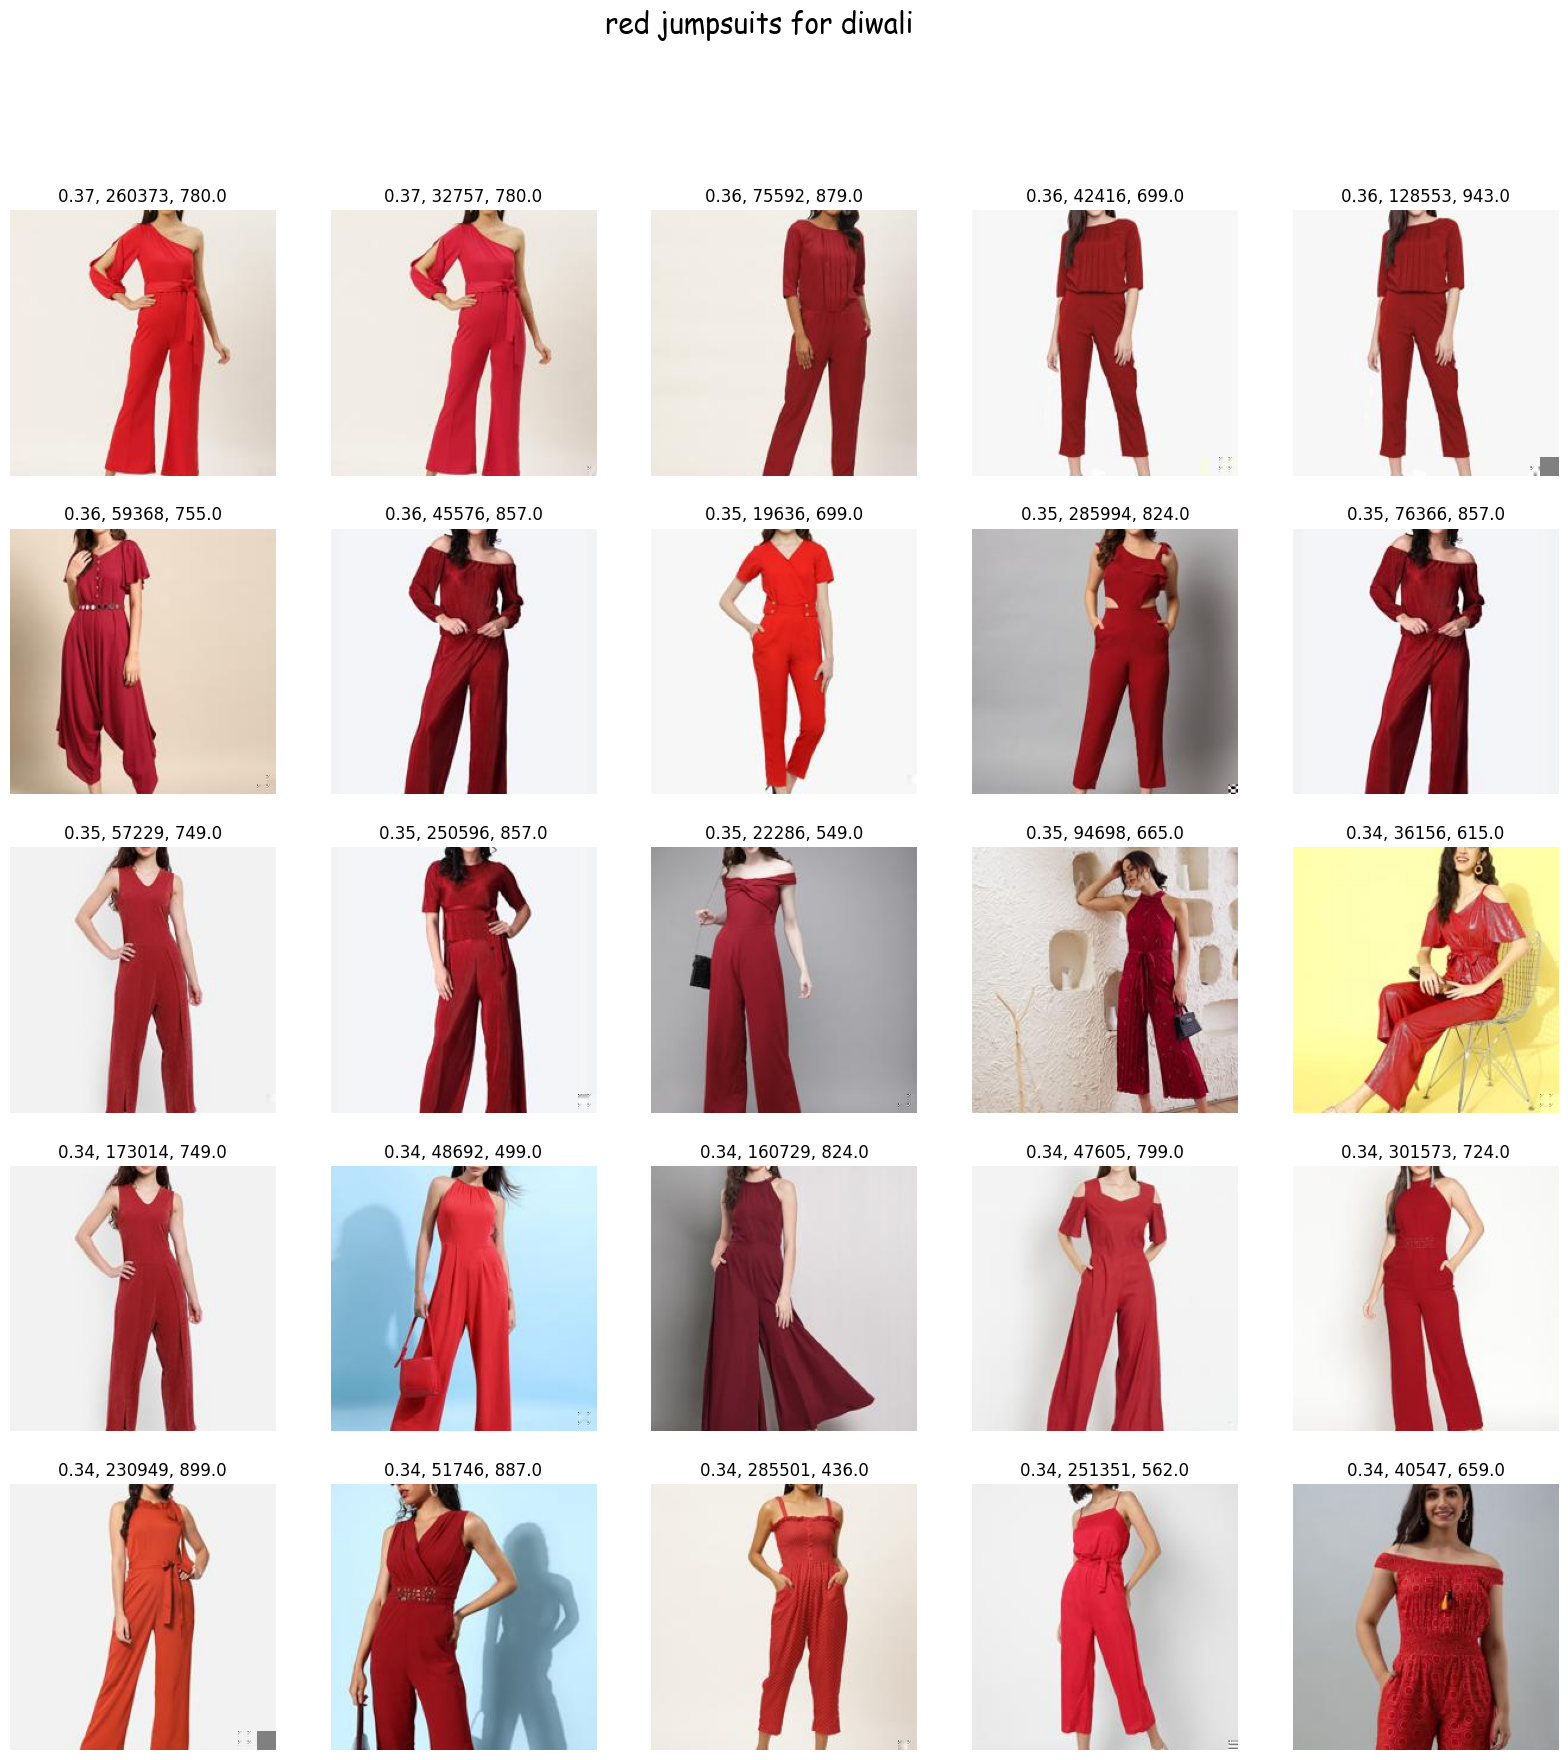

260373 : https://www.myntra.com/jumpsuit/dodo+%26+moa/dodo--moa-women-red-solid-one-shoulder-basic-jumpsuit/13798194/buy
32757 : https://www.myntra.com/jumpsuit/dodo+%26+moa/dodo--moa-one-shoulder-basic-jumpsuit/22174884/buy
75592 : https://www.myntra.com/jumpsuit/magnetic+designs/magnetic-designs-maroon-solid-basic-jumpsuit/17178160/buy
42416 : https://www.myntra.com/jumpsuit/magnetic+designs/magnetic-designs-women-maroon-basic-jumpsuit/20693038/buy
128553 : https://www.myntra.com/jumpsuit/magnetic+designs/magnetic-designs-women-maroon-basic-jumpsuit/20693018/buy
59368 : https://www.myntra.com/jumpsuit/anouk/anouk-embellished-culotte-jumpsuit-with-belt/24810532/buy
45576 : https://www.myntra.com/co-ords/popwings/popwings-polyester-self-design-off-shoulder-top--palazzos-/23389380/buy
19636 : https://www.myntra.com/jumpsuit/magnetic+designs/magnetic-designs-women-red-basic-jumpsuit/20693048/buy
285994 : https://www.myntra.com/jumpsuit/emeros/emeros-stylized-tie-up-one-shoulder-waist-cut

In [24]:
# ask('parachute pants')    
ask('red jumpsuits for diwali')
# similar(78481) 
# mashup_all([105301], 'short length bolero shrug', alpha=0.)

In [186]:
%%time
def get_probs(query):
    text = tokenizer([query])
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    return torch.nn.functional.cosine_similarity(image_embeddings, text_features.view(1, 512))

def plot_probs(queries):
    n = int(len(queries) ** 0.5)
    m = (len(queries) + n - 1) // n
    fig, axs = plt.subplots(n, m, figsize=(10, 10))
    for i, query in enumerate(queries):
        probs = get_probs(query)
        axs[i//m][i%m].hist(probs.tolist(), bins=500, range=(-0.1, 0.4))
        axs[i//m][i%m].set_title(query)
    plt.show()


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.11 µs


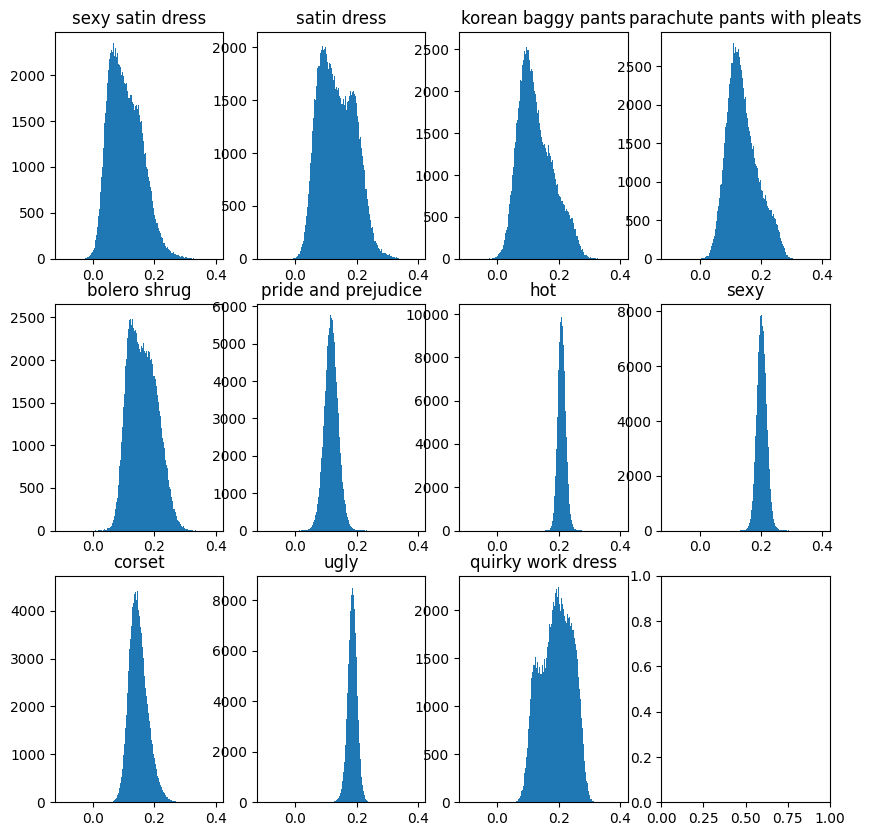

In [187]:
queries = ['sexy satin dress',
'satin dress',
'korean baggy pants',
'parachute pants with pleats',
'bolero shrug',
'pride and prejudice',
'hot', 
'sexy',
'corset',
'ugly',
'quirky work dress',
]

plot_probs(queries)